In [2]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
# uncomment these if you get install issues, then comment them back.
import torch
from torch import autograd, nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

    63% |████████████████████▍           | 377.1MB 17.2MB/s eta 0:00:13

    100% |████████████████████████████████| 592.3MB 42.2MB/s 
    100% |████████████████████████████████| 51kB 1.8MB/s 
    100% |████████████████████████████████| 5.9MB 225kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [3]:
training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(training_data, batch_size=256,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform = torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                         shuffle=False, num_workers=2)

# ordered class labels by idx
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


50000 training examples, 10000 test examples


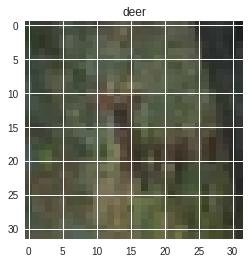

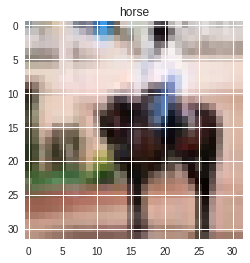

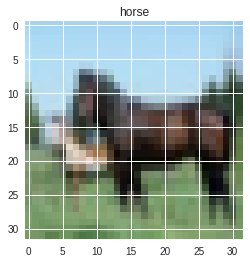

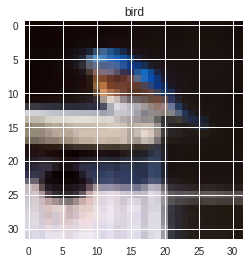

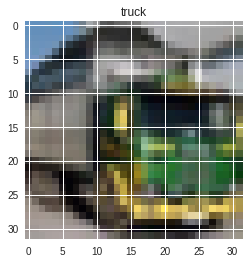

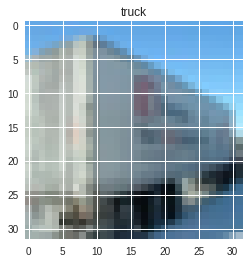

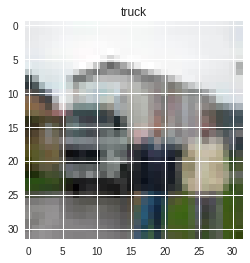

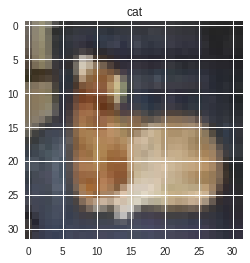

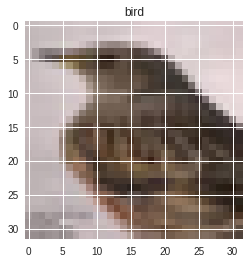

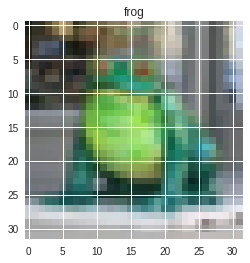

In [4]:
def plot_images(image_label_pairs):
    """Plot a list of images
    :param image_label_pairs: list of (image, label) pairs given by the dataset
    """
    for image, label in image_label_pairs:
        npimg = image.numpy()
        plt.figure()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(classes[label])
        plt.show()
    
n_train, n_test = len(training_data), len(test_data)
print("{} training examples, {} test examples".format(n_train, n_test))
# plot a few sample images
n = [training_data[i] for i in range(10, 20)]
plot_images(n)

In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size = 3, stride = 1)
        # response norm here
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # results in overlapping pooling
        self.conv2 = nn.Conv2d(96, 256, kernel_size = 3)
        # response norm here
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # results in overlapping pooling
#         self.conv3 = nn.Conv2d(256, 384, kernel_size = 2)
#         self.conv4 = nn.Conv2d(384, 384, kernel_size = 2)
#         self.conv5 = nn.Conv2d(384, 256, kernel_size = 2)
#         self.pool5 = nn.MaxPool2d(kernel_size = 1, stride = 1)
        # 2 fully connected layers followed by a softmax
        self.linear1 = nn.Linear(9216, 2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.out_layer = nn.Linear(2048, len(classes))
    
    def forward(self, x, train = True):
        # first layer transformation: conv -> relu -> pool
        x = self.pool1(F.relu(self.conv1(x)))
        # second layer transformation: conv -> relu -> pool
        x = self.pool2(F.relu(self.conv2(x)))
        # third, 4th layer transformation: conv -> relu
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         # 5th layer: conv -> relu -> pool
#         x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.linear1(x))
        # drop
        if train: x = F.dropout(x)
        x = F.relu(self.linear2(x))
        # drop
        if train: x = F.dropout(x)
        x = F.relu(self.out_layer(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [38]:
# initialize the network
alex_net = AlexNet()
alex_net.cuda()
alex_net

AlexNet(
  (conv1): Conv2d (3, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (96, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (linear1): Linear(in_features=9216, out_features=2048)
  (linear2): Linear(in_features=2048, out_features=2048)
  (out_layer): Linear(in_features=2048, out_features=10)
)

In [39]:
# define the loss and optimization function
loss = nn.CrossEntropyLoss()
opt = optim.SGD(alex_net.parameters(), lr = 0.01, momentum = 0.9) # TODO figure out how to reduce learning rate
dataiter = iter(trainloader)
print(n_train)
losses = []
for epoch in range(5000):
    opt.zero_grad()
    try:
        batch = next(dataiter)
    except StopIteration:
        dataiter = iter(trainloader)
        batch = next(dataiter)
    image_batch, label_batch = batch
    image_batch = autograd.Variable(image_batch).cuda()
    label_batch = autograd.Variable(label_batch).cuda()
    out_batch = alex_net.forward(image_batch).cuda()
    cur_loss = loss(out_batch, label_batch).cuda()
    cur_loss.backward()
    opt.step()
    losses.append(cur_loss)
    if epoch % 100 == 0:
        print("epoch: {}, loss: {}".format(epoch, cur_loss.data[0]))

print('done training! final loss: {}'.format(cur_loss.data[0]))

        

50000
train: True
epoch: 0, loss: 2.303149700164795
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True


train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
trai

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 500, loss: 1.8775036334991455
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 700, loss: 1.6650302410125732
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 900, loss: 1.6223745346069336
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 1100, loss: 1.5940792560577393
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
epoch: 1300, loss: 1.6830997467041016
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
trai

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 1800, loss: 1.2625328302383423
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 2000, loss: 1.023427963256836
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 2200, loss: 1.019142508506775
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 2400, loss: 0.7841019034385681
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 2600, loss: 0.786588191986084
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tra

epoch: 2800, loss: 0.5342025756835938
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
trai

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 3300, loss: 0.3795883357524872
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 3500, loss: 0.33773544430732727
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
t

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 3700, loss: 0.2143261432647705
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
tr

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 3900, loss: 0.28306567668914795
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
t

train: True
epoch: 4100, loss: 0.12290559709072113
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
t

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
trai

train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 4600, loss: 0.059835243970155716
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True


train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
epoch: 4800, loss: 0.012466749176383018
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True


train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
train: True
done training! final loss: 0.013227639719843864



 2.3031
[torch.cuda.FloatTensor of size 1 (GPU 0)]



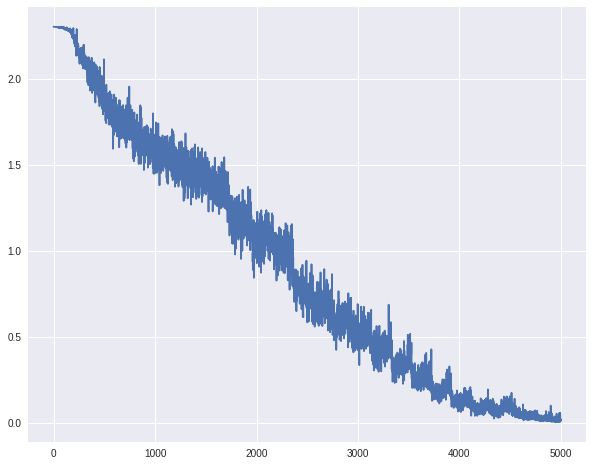

In [40]:
sampled_losses = losses[0:len(losses):1]
print(sampled_losses[0].data)
l = [loss.data for loss in sampled_losses]
plt.figure(figsize = (10,8))
plt.plot(l)

In [0]:
train_example, train_label = autograd.Variable(torch.stack([t[0] for t in training_data])).cuda(), autograd.Variable(torch.LongTensor([t[1] for t in training_data])).cuda()

In [42]:
train_outs = alex_net.forward(train_example[:1000])
predicted_output_classes = np.argmax(train_outs.data.cpu().numpy(), axis = 1)
actual_output_classes = train_label[:1000].data.cpu().numpy()
print('predicted: {}'.format(predicted_output_classes))
print('actual: {}'.format(actual_output_classes))
diffs = np.abs(predicted_output_classes - actual_output_classes)
errs = sum([1 if p != r else 0 for p, r in zip(predicted_output_classes, actual_output_classes)])
print('{} out of {} errs'.format(errs, actual_output_classes.shape[0]))

train: True
predicted: [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6 4 3 6 6 2 6 3 5 4 0 0 9 1 3 4 0 3
 7 3 3 5 2 2 7 1 1 1 2 2 0 9 5 7 9 2 2 5 2 4 3 1 1 8 2 1 1 4 9 7 8 5 9 6 7
 3 1 9 0 3 1 3 5 4 5 7 7 4 7 9 4 2 3 8 0 1 6 1 1 4 1 8 3 9 6 6 1 8 5 2 9 9
 8 1 7 7 0 0 6 9 1 2 2 9 2 6 6 1 9 5 0 4 7 6 7 1 8 1 1 2 8 1 3 3 6 2 4 9 9
 5 4 3 6 7 4 6 8 5 5 4 3 1 8 4 7 6 0 9 5 1 3 8 2 7 5 3 4 1 5 7 0 4 7 5 5 1
 0 9 6 9 0 8 7 8 8 2 5 2 3 5 0 6 1 9 3 6 9 1 3 9 6 6 7 1 0 9 5 8 5 2 9 0 8
 8 0 6 9 1 1 6 3 7 6 6 0 6 6 1 7 1 5 8 3 6 6 8 6 8 4 6 6 1 3 8 3 4 1 7 1 3
 8 5 1 1 4 0 9 3 7 4 9 9 2 4 9 9 1 0 5 9 0 8 2 1 2 0 5 6 3 2 7 8 8 6 0 7 9
 4 5 6 4 2 1 1 2 1 5 9 9 0 8 4 1 1 6 3 3 9 0 7 9 7 7 9 1 5 1 6 6 8 7 1 3 0
 3 3 2 4 5 7 5 9 0 3 4 0 4 4 6 0 0 6 6 0 8 1 6 2 9 2 5 9 6 7 4 1 8 7 3 6 9
 3 0 4 0 5 1 0 3 4 8 5 4 7 2 3 9 7 6 7 1 4 7 0 1 7 3 1 8 4 4 2 0 2 4 0 0 9
 0 9 6 8 2 7 7 4 0 3 0 8 9 4 2 7 2 5 2 5 1 9 4 8 5 1 7 4 4 0 6 9 0 7 8 8 9
 9 3 3 4 0 4 5 6 6 0 1 0 8 0 4 8 8 1 5 2 6 8 1 0 0 7 7 5 9 6 2 8 3 4 7 3 9
 0

In [0]:
test_examples, test_labels = autograd.Variable(torch.stack([t[0] for t in test_data])).cuda(), autograd.Variable(torch.LongTensor([t[1] for t in test_data])).cuda()

In [48]:
test_outs = alex_net.forward(test_examples[:1000], train = False)
pred_outs = np.argmax(test_outs.data.cpu().numpy(), axis = 1)
actual_outs = test_labels[:1000].data.cpu().numpy()
diffs = np.abs(pred_outs - actual_outs)
errs = sum([1 if p != r else 0 for p, r in zip(pred_outs, actual_outs)])
print('{} out of {} errs'.format(errs, actual_outs.shape[0]))

train: False
not dropping out
273 out of 1000 errs
